In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [90]:
mpl.rcParams['figure.figsize'] = 15, 10
plt.rcParams.update({'font.size': 16})


In [79]:
# Paths
op_budget_path = "data/fy23-adopted-operating-budget.csv"
earnings_20_path = "data/city-of-boston-calendar-year-2020-earnings.csv"
earnings_21_path = "data/employee-earnings-report-2021.csv"

# Read CSVs
e_20_df = pd.read_csv(earnings_20_path, encoding='ISO-8859-1')
e_21_df = pd.read_csv(earnings_21_path, encoding='ISO-8859-1')
op_budget_df = pd.read_csv(op_budget_path)

# Fix the Columns
e_20_df.columns = [c.strip() for c in e_20_df.columns]
e_21_df.columns = [c.strip() for c in e_21_df.columns]


In [80]:
# Handle the NaNs and negative numbers
import string

def remove_punc(text, replace_with=""):
    punc = string.punctuation.replace(".", "").replace("-","")
    text = text.strip()
    for p in punc:
        text = text.replace(p, replace_with)
        
    return text

def currency2num(x):
    series = []
    for i in x:
        if isinstance(i, str):
            series.append(max(float(remove_punc(i)), 0.0))
        else:
            series.append(i)
    return pd.Series(series)
    
cols_of_interest = ["REGULAR", "RETRO", "OTHER", "OVERTIME", "INJURED", "DETAIL", "QUINN_EDUCATION_INCENTIVE", "TOTAL_GROSS"]
cols_of_interest_20 = ["REGULAR", "RETRO", "OTHER", "OVERTIME", "INJURED", "DETAIL", "QUINN / EDUCATION INCENTIVE", "TOTAL EARNINGS"]

# Rename 2020 Columns (for Uniformity)
col_rename = dict(zip(cols_of_interest_20, cols_of_interest))
e_20_df.rename(columns=col_rename, inplace=True)

e_20_df[cols_of_interest] = e_20_df[cols_of_interest].fillna(0).apply(currency2num, axis=1)
e_21_df[cols_of_interest] = e_21_df[cols_of_interest].fillna(0).apply(currency2num, axis=1)

In [81]:
# Filtering to the Boston Police Department
e_21_df_bpd = e_21_df[e_21_df.DEPARTMENT_NAME == "Boston Police Department"]
e_20_df_bpd = e_20_df[e_20_df.DEPARTMENT_NAME == "Boston Police Department"]

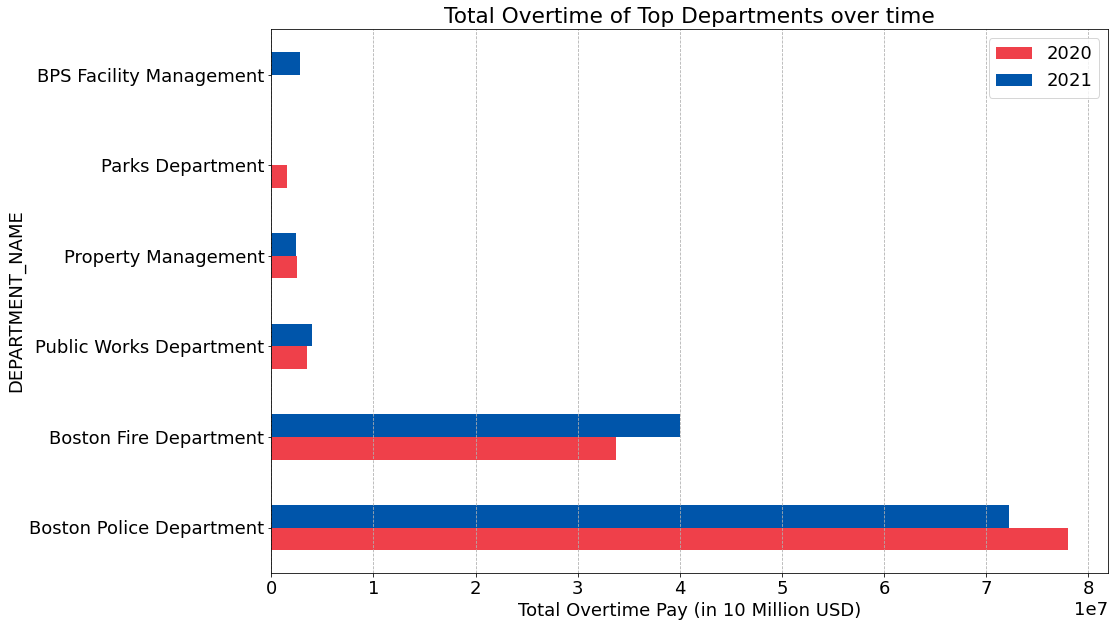

In [82]:
# 9. Total Overtime of Top Departments over time

n = 5

ot_df = pd.DataFrame(
    [
        e_20_df.groupby("DEPARTMENT_NAME").sum().sort_values(by="OVERTIME", ascending=False)[:n].OVERTIME,
        e_21_df.groupby("DEPARTMENT_NAME").sum().sort_values(by="OVERTIME", ascending=False)[:n].OVERTIME
    ],
    index=["2020", "2021"]
).transpose()

ax = ot_df.plot.barh(color=['#ef404a', '#0055aa'])
ax.grid(axis='x', linestyle='--')

plt.title("Total Overtime of Top Departments over time")
plt.xlabel("Total Overtime Pay (in 10 Million USD)")
plt.show()

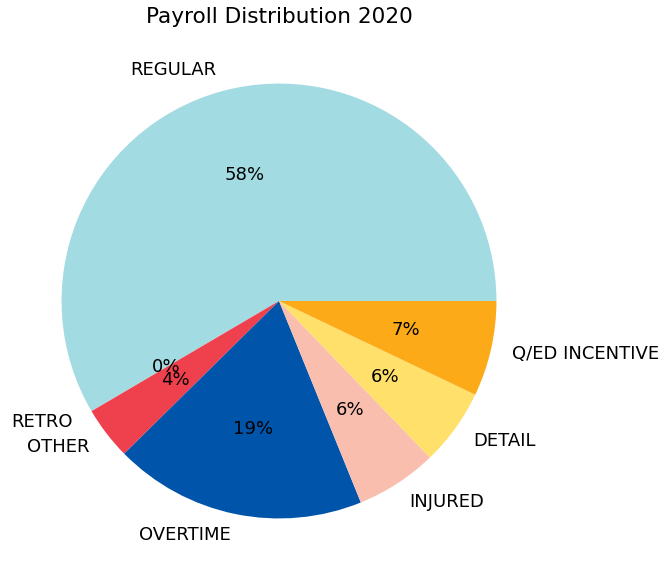

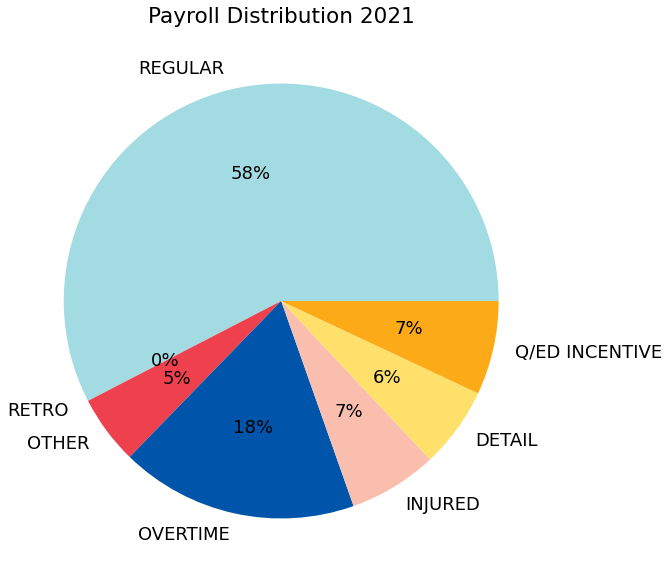

In [83]:
# 10. Payroll Distribution Over Time (base, overtime, retro, detail, etc.)

payroll_df = pd.DataFrame(
    [
        e_20_df_bpd[cols_of_interest].drop(columns=["TOTAL_GROSS"]).sum(),
        e_21_df_bpd[cols_of_interest].drop(columns=["TOTAL_GROSS"]).sum(),
    ],
    index=["2020", "2021"]
)
colors = ["#a3dbe3", "#a7d7b5", "#ef404e", "#0055aa", "#fabeaf", "#ffe06a", "#fcaa17"]

payroll_df.rename(columns={"QUINN_EDUCATION_INCENTIVE": "Q/ED INCENTIVE"}, inplace=True)

payroll_20_data = payroll_df.iloc[0].values
payroll_20_labels = payroll_df.columns

plt.pie(payroll_20_data, labels=payroll_20_labels, colors = colors, autopct='%.0f%%')
plt.title("Payroll Distribution 2020")
plt.show()

payroll_21_data = payroll_df.iloc[1].values
payroll_21_labels = payroll_df.columns

plt.pie(payroll_21_data, labels=payroll_21_labels, colors=colors, autopct='%.0f%%')
plt.title("Payroll Distribution 2021")
plt.show()

<Figure size 1584x864 with 0 Axes>

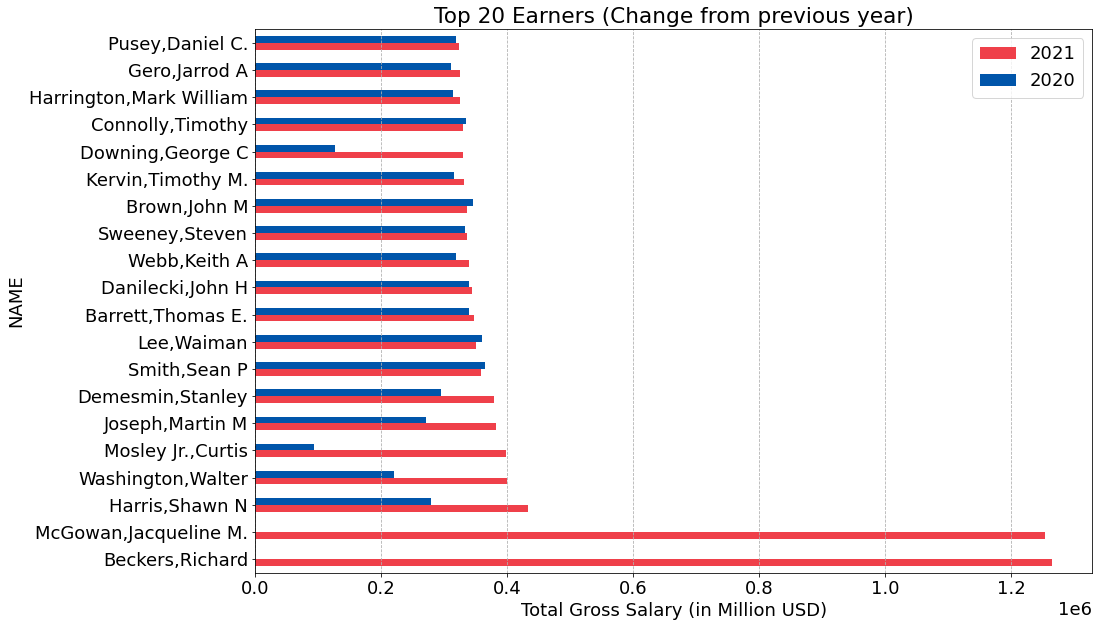

In [87]:
# 11. Top 20 Earners (Change from previous year)

top_20_total_21 = e_21_df_bpd.sort_values(by="TOTAL_GROSS", ascending=False).iloc[:20].reset_index()

same_20_from_21 = list()
for name in top_20_total_21.NAME:
    same_20_from_21.append(e_20_df_bpd[e_20_df_bpd.NAME == name].TOTAL_GROSS.values)
    

same_20_from_21 = pd.DataFrame(same_20_from_21, columns=["TOTAL_GROSS"])
same_20_from_21["NAME"] = top_20_total_21.NAME.values


ot_df = pd.DataFrame(
    [
        top_20_total_21.set_index("NAME").TOTAL_GROSS,
        same_20_from_21.set_index("NAME").TOTAL_GROSS

    ],
    index=["2021", "2020"]
).transpose()

plt.figure(figsize=(22, 12))
ax = ot_df.plot.barh(color=['#ef404a', '#0055aa'])
ax.grid(axis='x', linestyle='--')
plt.title("Top 20 Earners (Change from previous year)")
plt.xlabel("Total Gross Salary (in Million USD)")
plt.show()

In [88]:
# 12. Top 20 earners from the most recent year (2021) - (OT, Base, Other)

top_20_base_21 = e_21_df_bpd.sort_values(by="REGULAR", ascending=False).iloc[:20] # Top 20 by base pay (regular)
top_20_ot_21 = e_21_df_bpd.sort_values(by="OVERTIME", ascending=False).iloc[:20] # Top 20 by base pay (Overtime)
top_20_others_21 = e_21_df_bpd.sort_values(by="OTHER", ascending=False).iloc[:20] # Top 20 by base pay (Other)

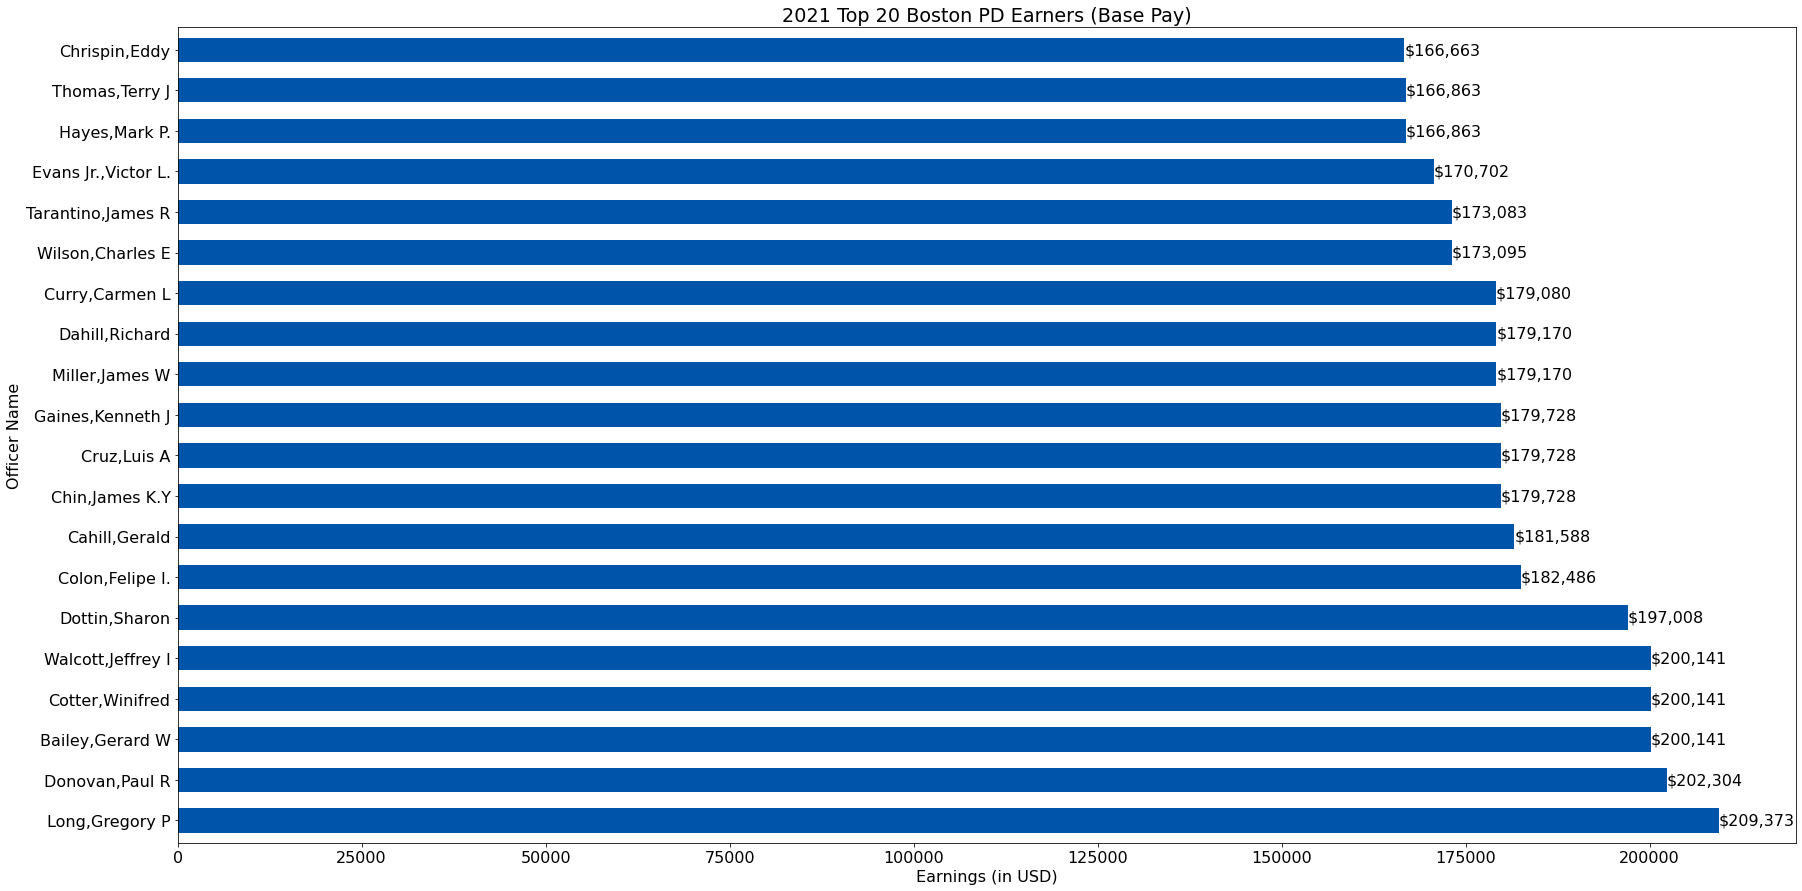

In [102]:
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(29, 15))
ax = top_20_base_21.set_index("NAME")["REGULAR"].plot.barh(width = 0.6, color=['#0055aa'])
for container in ax.containers:
    ax.bar_label(container, labels=[f'${x:,.0f}' for x in container.datavalues])

plt.title("2021 Top 20 Boston PD Earners (Base Pay)")
plt.xlabel("Earnings (in USD)")
plt.ylabel("Officer Name")
plt.show()

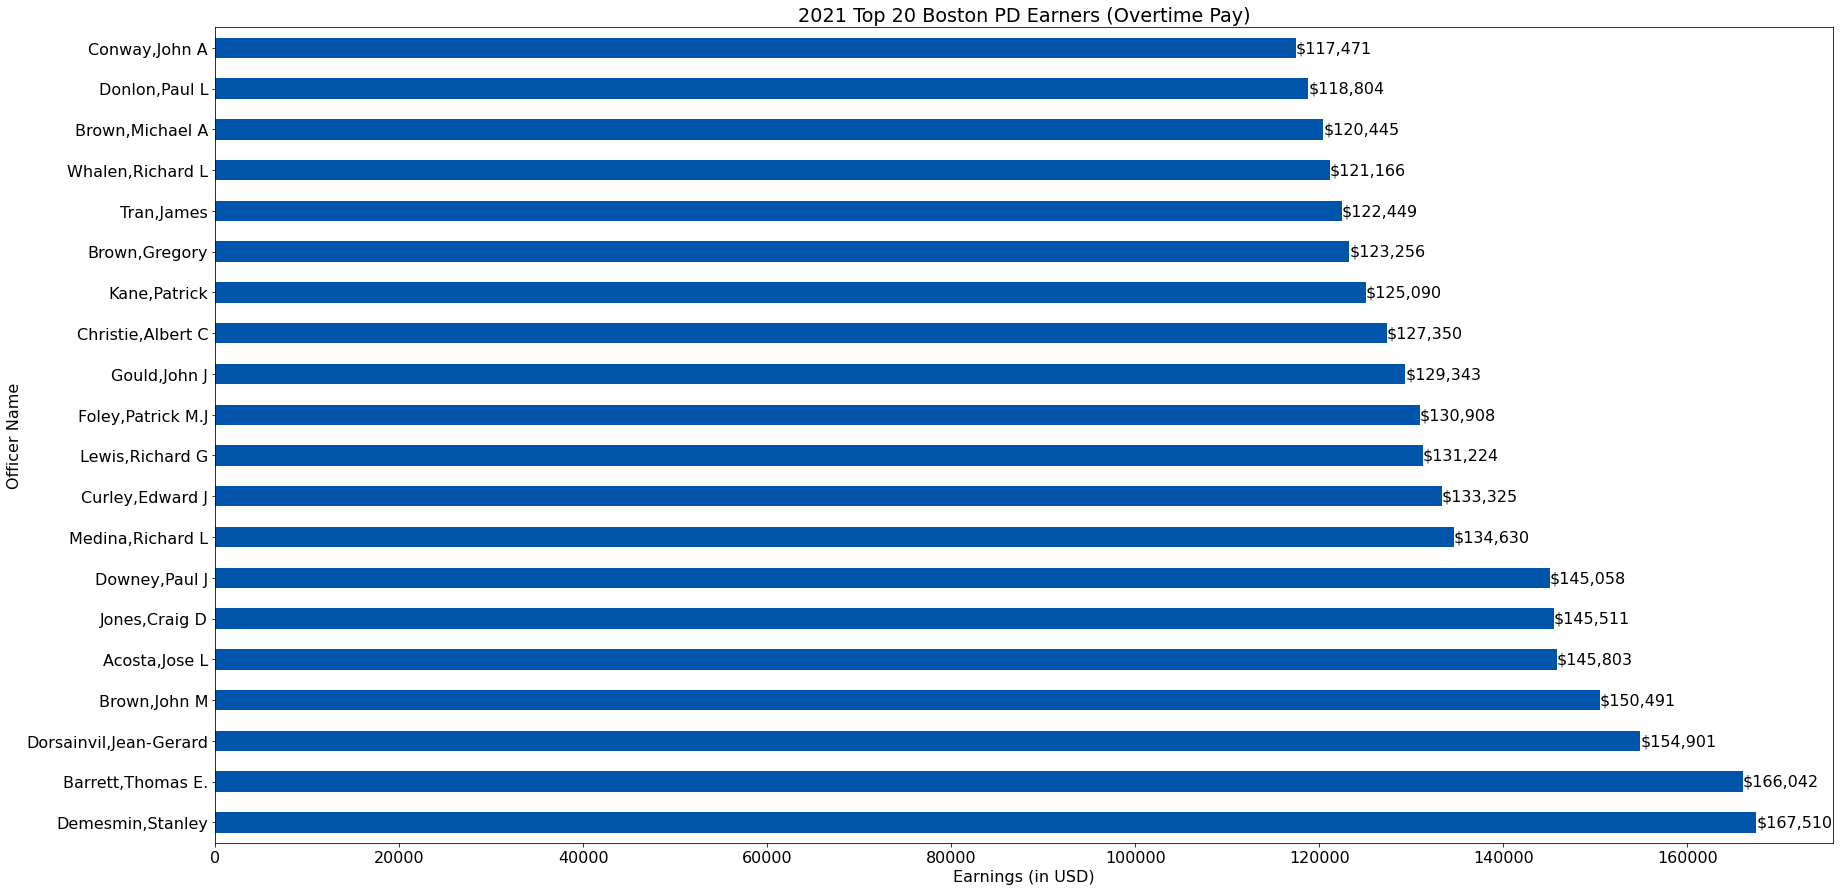

In [103]:
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(29, 15))
ax = top_20_ot_21.set_index("NAME")["OVERTIME"].plot.barh(color=['#0055aa'])
for container in ax.containers:
    ax.bar_label(container, labels=[f'${x:,.0f}' for x in container.datavalues])
plt.title("2021 Top 20 Boston PD Earners (Overtime Pay)")
plt.xlabel("Earnings (in USD)")
plt.ylabel("Officer Name")
plt.show()

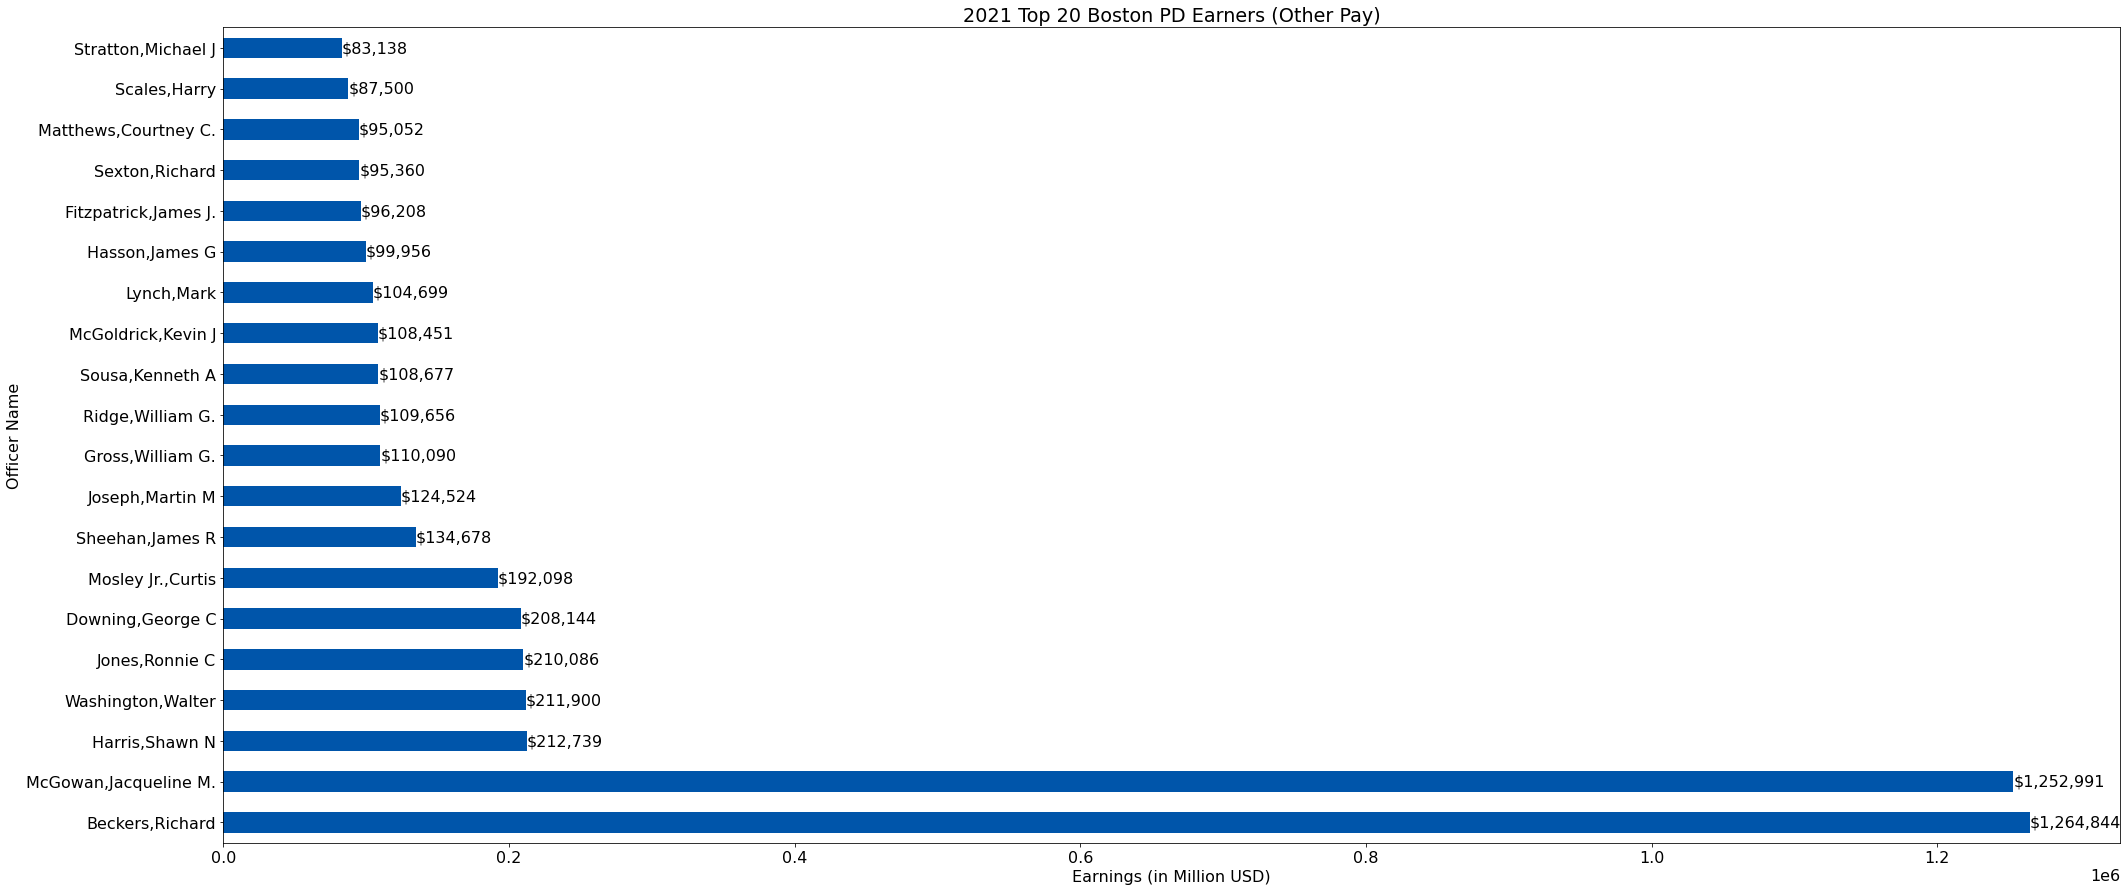

In [108]:
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(34, 15))
ax = top_20_others_21.set_index("NAME")["OTHER"].plot.barh(color=['#0055aa'])

for container in ax.containers:
    ax.bar_label(container, labels=[f'${x:,.0f}' for x in container.datavalues])
plt.title("2021 Top 20 Boston PD Earners (Other Pay)")
plt.xlabel("Earnings (in Million USD)")
plt.ylabel("Officer Name")
plt.show()

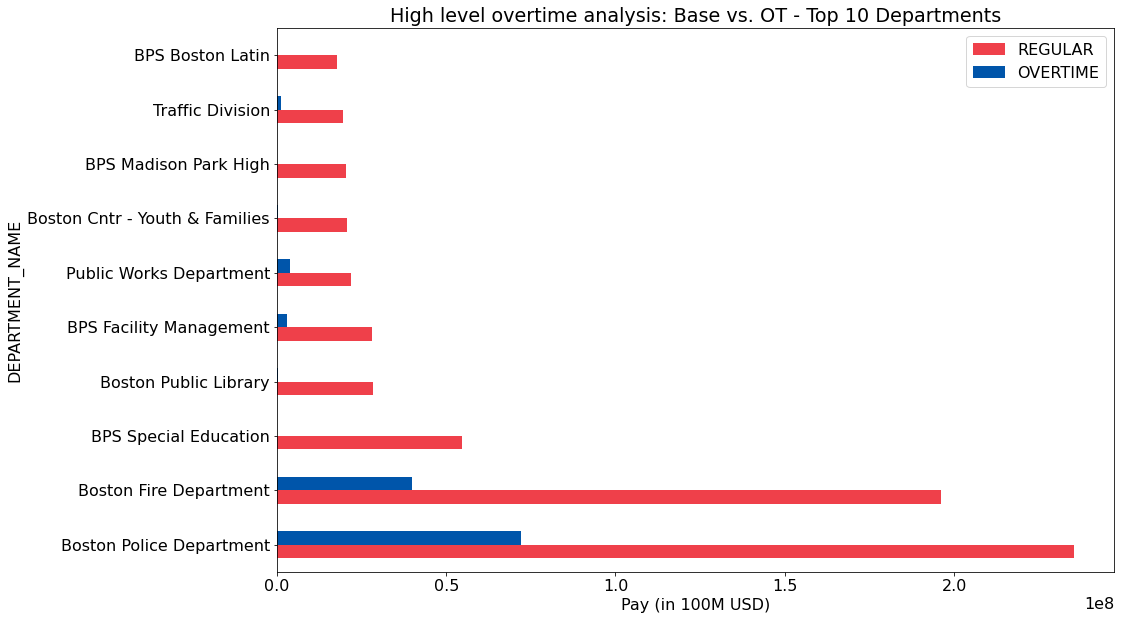

In [109]:
# 13 High level overtime analysis (base salary vs. overtime vs. other departments) 
n = 10
e_21_df.groupby("DEPARTMENT_NAME").sum().sort_values(
    by="REGULAR", ascending=False)[:n][["REGULAR", "OVERTIME"]].plot.barh(color=['#ef404a', '#0055aa'])
plt.title(f"High level overtime analysis: Base vs. OT - Top {n} Departments")
plt.xlabel("Pay (in 100M USD)")
plt.show()

<Figure size 1584x1080 with 0 Axes>

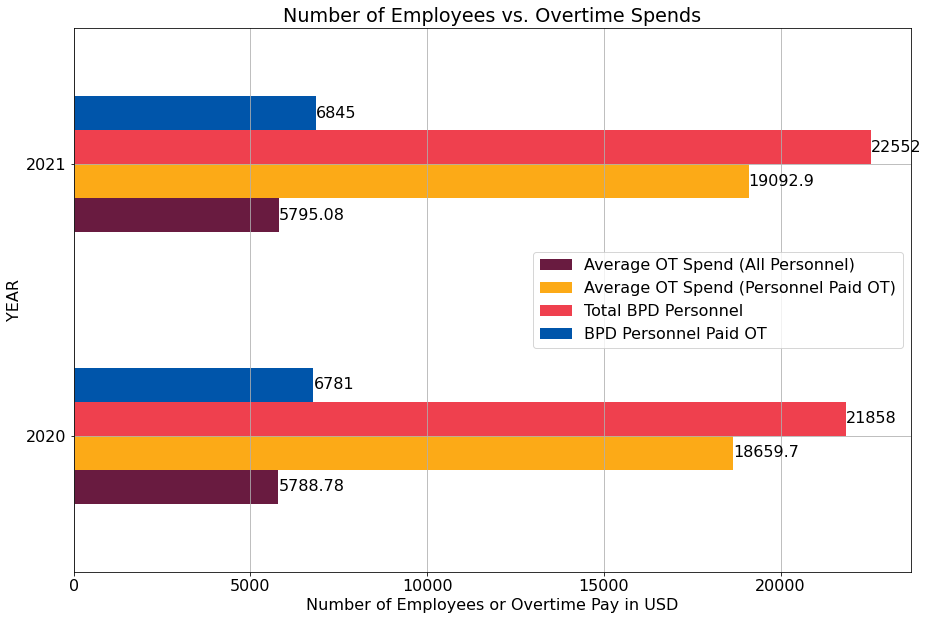

In [115]:
# 14. # of employees vs. OT Spends


yearly_ot_df = pd.DataFrame(
    {
        "Total OT Spend": [
            e_20_df.OVERTIME.sum(),
            e_21_df.OVERTIME.sum(),
        ],
        "Average OT Spend (All Personnel)": [
            e_20_df.OVERTIME.mean(),
            e_21_df.OVERTIME.mean(),
        ],
        "Average OT Spend (Personnel Paid OT)": [
            e_20_df[e_20_df.OVERTIME > 0].OVERTIME.mean(),
            e_21_df[e_21_df.OVERTIME > 0].OVERTIME.mean(),
        ], 
        "Total BPD Personnel":
        [
            len(e_20_df),
            len(e_21_df),
        ],
        "BPD Personnel Paid OT":
        [
            len(e_20_df[e_20_df.OVERTIME > 0]),
            len(e_21_df[e_21_df.OVERTIME > 0]),
        ]
    },
    index=["2020", "2021"]
)

plt.rcParams.update({'font.size': 16})

plt.rcParams["figure.figsize"] = (20,3)
ax = yearly_ot_df.drop(columns=["Total OT Spend"]).plot.barh(color=["#691b40", "#fcaa17", "#ef404e", "#0055aa",])
for container in ax.containers:
    ax.bar_label(container)
plt.title("Number of Employees vs. Overtime Spends")
plt.xlabel("Number of Employees or Overtime Pay in USD")
plt.ylabel("YEAR")
plt.grid()
plt.show()
# plt.ylim(0, 35000)
# plt.show()
# yearly_ot_df[["Average OT Spend (All Personnel)", "Total BPD Personnel"]].plot.bar()
# plt.ylim(0, 30000)
# plt.show()
# yearly_ot_df[["Average OT Spend (Personnel Paid OT)", "BPD Personnel Paid OT"]].plot.bar()
# plt.ylim(0, 30000)
# plt.show()